In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xlrd
import math

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, f_oneway
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, f1_score, accuracy_score

from scipy.io import loadmat
from scipy.stats import pearsonr, spearmanr
from scipy import stats
from scipy.spatial.distance import cdist
from scipy.fftpack import fft, fftfreq, fftn
import numpy.fft as npfft

import pywt
from sampen import sampen2
from PyEMD import EMD, EEMD, CEEMDAN
from pyentrp import entropy

import lightgbm as lgb
from lightgbm import LGBMClassifier

from tqdm import tqdm

# MySelf From 时频特征CWRU测试.ipynb 

## 时域特征

In [2]:
def margin(x):
    ptp = x.ptp()
    data = np.sqrt(abs(x))
    df_margin=(ptp) / (pow(data.mean(),2)+1e-10)
    return df_margin

def _roll(a, shift):
    if not isinstance(a, np.ndarray):
        a = np.asarray(a)
    idx = shift % len(a)
    return np.concatenate([a[-idx:], a[:-idx]])

def peaks(x, n):
    x_reduced = x[n:-n]
    res = None
    for i in range(1, n + 1):
        result_first = (x_reduced > _roll(x, i)[n:-n])
        if res is None:
            res = result_first
        else:
            res &= result_first
        res &= (x_reduced > _roll(x, -i)[n:-n])
    return np.sum(res)

def soreoccurring(x):
    unique, counts = np.unique(x, return_counts=True)
    counts[counts < 2] = 0
    counts[counts > 1] = 1
    return np.sum(counts * unique)

def pereoccurring_all(x):
    if not isinstance(x, pd.Series):
        x = pd.Series(x)
    if x.size == 0:
        return np.nan
    value_counts = x.value_counts()
    reoccuring_values = value_counts[value_counts > 1].sum()
    if np.isnan(reoccuring_values):
        return 0
    return reoccuring_values / x.size

def datapoint(x):
    if len(x) == 0:
        return np.nan
    unique, counts = np.unique(x, return_counts=True)
    if counts.shape[0] == 0:
        return 0
    return np.sum(counts > 1) / float(counts.shape[0])

def stat(data:pd.Series,c:dict,name:str):
    c[name + '_max'] = data.max()
    c[name + '_min'] = data.min()
    c[name + '_mean'] = data.mean()
    c[name + '_ptp'] = data.max() - data.min() # data.ptp()
    c[name + '_std'] = data.std()
    c[name + '_var'] = data.var()
    c[name + '_median'] = data.median()
    c[name + '_kurt'] = data.kurt()
    c[name + '_mode'] = data.mode()[0]
    c[name + '_mad'] = np.median(np.abs(data - data.median()))
    
    c[name + '_rms'] = np.sqrt(np.mean(pow(c[name + '_mean'], 2)))
    c[name + '_margin'] = margin(data) #裕度
    c[name + '_boxing'] = c[name + '_rms'] / (abs(data).mean()+1e-10)#波形
    c[name + 'fengzhi'] =(c[name + '_ptp']) / (c[name + '_rms']+1e-10)#峰值
    c[name + 'maichong'] =(c[name + '_ptp']) / (abs(data).mean()+1e-10)#脉冲
    c[name+'_peaks10']=peaks(data,10)
    c[name+'_peaks50']=peaks(data,50)
    c[name+'_soreoccurring']=soreoccurring(data)
    c[name+'_pereoccurring_all']=pereoccurring_all(data)
    c[name+'_datapoint']=datapoint(data)
    
    c[name + '_max_mode'] = c[name + '_max'] / c[name + '_mode']
    c[name + '_min_mode'] = np.abs(c[name + '_min'] / c[name + '_mode'])
    c[name + '_mean_mode'] = np.abs(c[name + '_mean'] / c[name + '_mode'])
    c[name + '_median_mode'] = np.abs(c[name + '_median'] / c[name + '_mode'])


    c[name + '_05'] = data.quantile(.05)
    c[name + '_25'] = data.quantile(.25)
    c[name + '_75'] = data.quantile(.75)
    c[name + '_95'] = data.quantile(.95)
    return c

In [3]:
# 时频统计特征
def get_features(df, is_fft=False):
    
    mean_list = []
    std_list = []
    var_list = []
    min_list = []
    max_list = []
    median_list = []
    skew_list = []
    kuri_list = []
    sum_list = []
    abs_sum_list = []
    sum_abs_list = []
    abs_max_list = []
    abs_min_list = []
    per_95_list = [] # 95分位
    per_5_list = []  # 5分位
    per_25_list = []
    per_75_list = []
    jueduijunzhi_list = [] # 绝对均值
    rms_list = []  # 均方根值
    fanggenfuzhi_list = []  # 方根幅值
    waixiedu_list = []  # 歪斜度
    fengzhi_list = []  # 峰值
    fengzhiyinzi_list = []  # 峰值因子
    fengzhizhibiao_list = []  # 峰值指标
    qiaoduzhibiao_list = []  # 峭度指标
    boxingzhibiao_list = []  # 波形指标
    maichongyinzi_list = []  # 脉冲因子
    maichongzhibiao_list = []  # 脉冲指标
    yuduyinzi_list = []  # 裕度因子
    yuduzhibiao_list = [] # 裕度指标
    x = pd.DataFrame()
    for i in range(len(df)):
        mean_list.append(np.mean(df.iloc[i].values))
        std_list.append(np.std(df.iloc[i].values))
        var_list.append(np.var(df.iloc[i].values))
        min_list.append(np.min(df.iloc[i].values))
        max_list.append(np.max(df.iloc[i].values))
        median_list.append(np.median(df.iloc[i].values))
        skew_list.append(stats.skew(df.iloc[i].values))
        kuri_list.append(stats.kurtosis(df.iloc[i].values))
        sum_list.append(np.sum(df.iloc[i].values))
        abs_sum_list.append(np.abs(np.sum(df.iloc[i].values)))
        sum_abs_list.append(np.sum(np.abs(df.iloc[i].values)))
        abs_min_list.append(np.min(np.abs(df.iloc[i].values)))
        abs_max_list.append(np.max(np.abs(df.iloc[i].values)))
        per_95_list.append(np.percentile(df.iloc[i].values, q=95))
        per_5_list.append(np.percentile(df.iloc[i].values, q=5))
        per_25_list.append(np.percentile(df.iloc[i].values, q=25))
        per_75_list.append(np.percentile(df.iloc[i].values, q=75))
        jueduijunzhi_list.append(np.mean(np.abs(df.iloc[i].values)))
        rms_list.append(np.sqrt(np.mean(np.power(df.iloc[i].values, 2))))
        fanggenfuzhi_list.append(np.power(np.mean(np.sqrt(np.abs(df.iloc[i].values))), 2))
        waixiedu_list.append(np.mean(np.power(df.iloc[i].values, 3)))
        boxingzhibiao_list.append(float(rms_list[-1] / jueduijunzhi_list[-1]))
        fengzhizhibiao_list.append(float(max_list[-1] / rms_list[-1]))
        maichongzhibiao_list.append(float(max_list[-1] / jueduijunzhi_list[-1]))
        yuduzhibiao_list.append(float(max_list[-1] / fanggenfuzhi_list[-1]))
        qiaoduzhibiao_list.append(float(np.mean(np.power(df.iloc[i].values, 4)) / np.power(rms_list[-1], 4)))
        fengzhi_list.append(float(max_list[-1] + min_list[-1]) / 2)
        fengzhiyinzi_list.append(float(fengzhi_list[-1] / rms_list[-1]))
        maichongyinzi_list.append(float(fengzhi_list[-1] / jueduijunzhi_list[-1]))
        yuduyinzi_list.append(float(fengzhi_list[-1] / fanggenfuzhi_list[-1]))
        
    x['mean'] = mean_list
    x['std'] = std_list
    x['var'] = var_list
    x['min'] = min_list
    x['max'] = max_list
    x['median'] = median_list
    x['skew'] = skew_list
    x['kuri'] = kuri_list
    x['sum'] = sum_list
    x['abs_sum'] = abs_sum_list
    x['sum_abs'] = sum_abs_list
    x['abs_min'] = abs_min_list
    x['abs_max'] = abs_max_list
    x['per_95'] = per_95_list
    x['per_5'] = per_5_list
    x['per_25'] = per_25_list
    x['per_75'] = per_75_list
    x['jueduijunzhi'] = jueduijunzhi_list
    x['rms'] = rms_list
    x['fanggenfuzhi'] = fanggenfuzhi_list
    x['waixiedu'] = waixiedu_list
    x['boxingzhibiao'] = boxingzhibiao_list
    x['fengzhizhibiao'] = fengzhizhibiao_list
    x['maichongzhibiao'] = maichongzhibiao_list
    x['yuduzhibiao'] = yuduzhibiao_list
    x['qiaoduzhibiao'] = qiaoduzhibiao_list
    x['fengzhi'] = fengzhi_list
    x['fengzhiyinzi'] = fengzhiyinzi_list
    x['maichongyinzi'] = maichongyinzi_list
    x['yuduyinzi'] = yuduyinzi_list
    
    
    if is_fft:
        x.columns = [col + '_fft'  for col in x.columns]
    return x 

In [57]:
def get_time_domain_features(data):
    '''data: 1-d array'''
    
    # ================有量纲指标=================
    x_mean = np.mean(data)
    x_std = np.std(data)
    
    data_norm = data - x_mean
    x_rms2 = np.sum(data_norm**2) / len(data_norm)  # 均方值
    x_rms = np.sqrt(x_rms2) # 均方根值（有效值）
    x_max = np.max(data_norm)
    x_min = np.min(data_norm)
    x_p = max(np.abs(x_max), np.abs(x_min))
    x_pp = x_max - x_min
    x_avg = np.mean(np.abs(data_norm)) # 平均绝对幅值
    x_r = np.mean(np.sqrt(np.abs(data_norm)))**2 # 方根幅值
    x_alpha = np.mean(np.power(data_norm, 3)) # 偏度(歪度)
    x_beta = np.mean(np.power(data_norm, 4)) # 峭度
    
    # ================无量纲指标=================
    x_wf = x_rms / x_avg # 波形指标
    x_cf = x_pp / x_rms  # 峰值指标
    x_if = x_pp / x_avg  # 脉冲指标
    x_clf = x_pp / x_r   # 裕度指标
    x_pf = x_alpha / x_rms ** 3  # 偏度指标
    x_kf = x_beta/ x_rms ** 4  # 峭度指标
    
    time_domain_features_list = [x_mean, x_std, x_rms2, x_rms, x_max, x_min, x_p, x_pp, x_avg, x_r, x_alpha, x_beta, x_wf, x_cf, x_if, x_clf, x_pf, x_kf]
    time_domain_names_list = ['平均值', '方差', '均方值', '均方根值', '最大值', '最小值', '峰值', '峰峰值', '平均绝对幅值', 
                              '方根幅值', '偏度', '峭度', '波形指标', '峰值指标', '脉冲指标', '裕度指标', '偏度指标', '峭度指标']
    for i in range(len(time_domain_names_list)):
        print(time_domain_names_list[i],':',time_domain_features_list[i])
        
    return time_domain_features_list, time_domain_names_list

## 频域特征

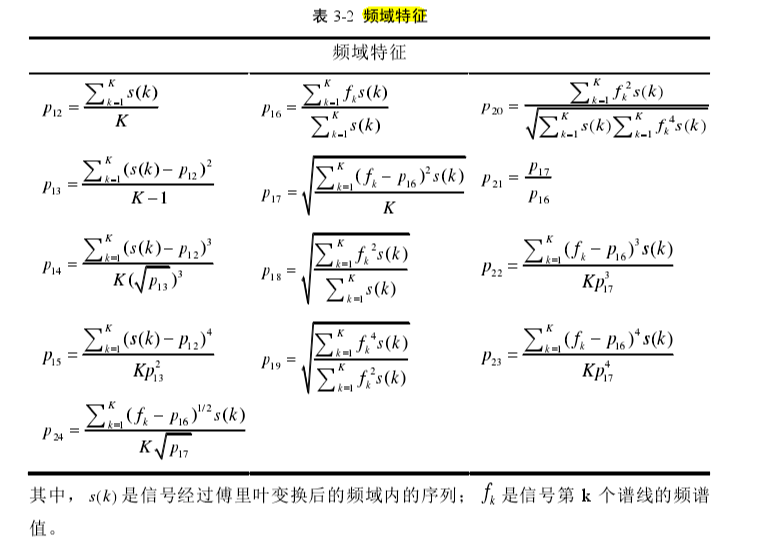

In [58]:
def get_freq_features(data, fs):
    signal_ = np.array(data)
    Fs = fs # 采样频率 such as 12k
    L = len(signal_)
    PL = abs(np.fft.fft(signal_ / L))[:int(L/2)]
    PL[0] = 0
    f = np.fft.fftfreq(L, 1/Fs)[:int(L/2)]
    x = f # 频率 hz
    y = PL # 幅值
    K = len(y)
    
    f1 = np.mean(y)
    f2 = np.var(y)
    f3 = (np.sum((y - f1)**3)) / (K*((np.sqrt(f2))**3))
    f4 = (np.sum((y-f1)**4)) / (K*((f2)**2))
    f5 = np.sum(x*y) / np.sum(y)
    f6 = np.sqrt((np.mean(((x- f_5)**2)*(y)))) 
    f7 = np.sqrt((np.sum((x**2)*y))/(np.sum(y))) 
    f8 = np.sqrt((np.sum((x**4)*y))/(np.sum((x**2)*y))) 
    f9 = np.sqrt((np.sum((x**2)*y))/((np.sum(y))*(np.sum((x**4)*y)))) 
    f10 = f_6 / f_5
    f11 = (np.sum(((x - f_5)**3)*y))/(K * (f_6**3)) 
    f12 = (np.sum(((x - f_5)**4)*y))/(K * (f_6**4))
    f13 = np.sum(np.sqrt(x - f5) * y) / (K*np.sqrt(f6))
    f_feat = [f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13]
    return f_feat


## 样本熵/排列熵

In [4]:
'''慢慢慢'''

def get_emd_entrp_features(df):
    Ens = []
    
    for sample_id in range(len(df)):
        signal = df.iloc[sample_id].values
        eIMFs = eemd.eemd(signal, max_imf=3)
        nIMFs = eIMFs.shape[0]
        
        samE = []
        perE = []
        for i in range(nIMFs):
            samE.append(sampen2(eIMFs[i].tolist(), mm=2, r=0.2, normalize=True)[-1][1])
            
        for j in range(nIMFs):
            perE.append(entropy.permutation_entropy(eIMFs[j], order=3, delay=1, normalize=True))
            
        # this sample [样本熵:置换熵]
        En = samE + perE
        Ens.append(En)
        
    features = pd.DataFrame(Ens, columns=['IMFSE%d' %d for d in range(1, nIMFs+1)] + ['IMFPE%d' %d for d in range(1, nIMFs+1)])
    return features

## 小波能量熵

In [5]:
def get_wp_entrp(df, n=3):
    features = []
    cols = []
    for i in range(len(df)):
        this_sample = df.iloc[i].values
        wp = pywt.WaveletPacket(this_sample, wavelet='db3', maxlevel=n ,mode='symmetric')
        sample_EE = []
        for level in range(n, n+1): # only use the last level
            tmp = []
            for node in [node.path for node in wp.get_level(level, 'freq')]:
                if i == 0:
                    cols.append(node)
                data = np.array(wp[node].data)
                Eji = np.power(np.linalg.norm(data, ord=None), 2)
                tmp.append(Eji) # 第i个样本第level层的第j个节点, level层有2**level个节点
            tmp = np.array(tmp)
            Ej = tmp.sum()
            Pji = tmp / Ej
            Wji = -1 * Pji * np.log(Pji)
            sample_EE.extend(Wji.tolist())
        features.append(sample_EE)
        
    x = pd.DataFrame(features, columns=cols)
    return x

## 小波能量

In [6]:
def get_wp_features(df, n=3):
    x = pd.DataFrame()
    for i in range(len(df)):
        this_sample = df.iloc[i].values
        wp = pywt.WaveletPacket(this_sample, wavelet='db3', maxlevel=n ,mode='symmetric')
        re = {}
        for level in range(n, n+1):
            for node in [node.path for node in wp.get_level(level, 'freq')]:
                re[node] = wp[node].data
                
        energy = pd.DataFrame()
        for k in re:
            energy[k] = [np.power(np.linalg.norm(re[k], ord=None), 2)]
            
        x = pd.concat([x, energy], axis=0)
    x.reset_index(inplace=True, drop=True)
    return x


# Code From Github
- https://github.com/HappyBoy-cmd/fault_diagnosis_signal_processing

## FFT

Text(0.5, 1.0, 'FFT domain')

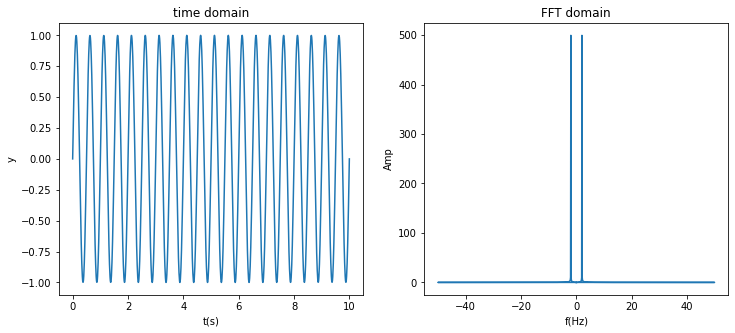

In [17]:
t = np.linspace(0,10,num=1000) # 采样频率fs=1000÷10=100
y = np.sin(2*np.pi*t*2) # y=sin(2*π*f*t) # 这里f=2

fig = plt.figure(figsize=(12, 5))
ax1 = plt.subplot(1, 2, 1)
plt.plot(t, y)  
plt.xlabel('t(s)') 
plt.ylabel('y')
plt.title('time domain')

fs = 100 # 采样频率
xf = np.fft.fft(y) # 对离散数据y做fft变换得到变换之后的数据xf
xfp = np.fft.fftfreq(n=len(y), d=1/fs) #fftfreq(length，d)，计算得到频率 d:Sample spacing (inverse of the sampling rate)
xf = np.abs(xf) # 将复数求模

ax1 = plt.subplot(1, 2, 2) 
plt.plot(xfp, xf) # 画fft图像
plt.xlabel('f(Hz)') 
plt.ylabel('Amp')
plt.title('FFT domain')

Text(0.5, 1.0, 'y=sin(2*π*2*t) f=2 fft')

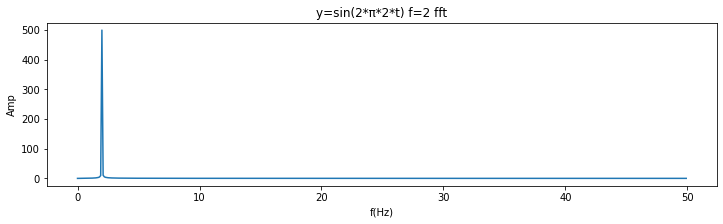

In [18]:
# 对称取一半
xf = np.fft.fft(y)   
xf = np.abs(xf) 
xf = xf[0:int(len(xf)/2)]  
xfp = np.fft.fftfreq(len(y), d=1 / fs)
xfp = xfp[0:int(len(xfp)/2)] 

plt.figure(figsize=(12,3))
plt.plot(xfp, xf) 
plt.xlabel('f(Hz)') 
plt.ylabel('Amp')
plt.title('y=sin(2*π*2*t) f=2 fft')

Text(0.5, 1.0, 'y=sin(2*π*2*t) f=2 fft')

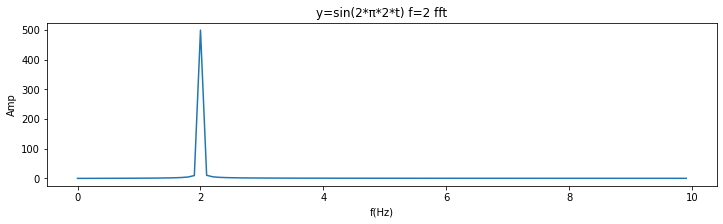

In [21]:
plt.figure(figsize=(12,3))
plt.plot(xfp[:100], xf[:100]) 
plt.xlabel('f(Hz)') 
plt.ylabel('Amp')
plt.title('y=sin(2*π*2*t) f=2 fft')

In [59]:
def get_freq_features(data, fs):
    signal_ = np.array(data)
    Fs = fs # 采样频率 such as 12k
    L = len(signal_)
    PL = abs(np.fft.fft(signal_ / L))[:int(L/2)]
    PL[0] = 0
    f = np.fft.fftfreq(L, 1/Fs)[:int(L/2)]
    x = f # 频率 hz
    y = PL # 幅值
    K = len(y)
    
    f1 = np.mean(y)
    f2 = np.var(y)
    f3 = (np.sum((y - f1)**3)) / (K*((np.sqrt(f2))**3))
    f4 = (np.sum((y-f1)**4)) / (K*((f2)**2))
    f5 = np.sum(x*y) / np.sum(y)
    f6 = np.sqrt((np.mean(((x- f_5)**2)*(y)))) 
    f7 = np.sqrt((np.sum((x**2)*y))/(np.sum(y))) 
    f8 = np.sqrt((np.sum((x**4)*y))/(np.sum((x**2)*y))) 
    f9 = np.sqrt((np.sum((x**2)*y))/((np.sum(y))*(np.sum((x**4)*y)))) 
    f10 = f_6 / f_5
    f11 = (np.sum(((x - f_5)**3)*y))/(K * (f_6**3)) 
    f12 = (np.sum(((x - f_5)**4)*y))/(K * (f_6**4))
    f13 = np.sum(np.sqrt(x - f5) * y) / (K*np.sqrt(f6))
    f_feat = [f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12, f13]
    return f_feat


## 小波包能量

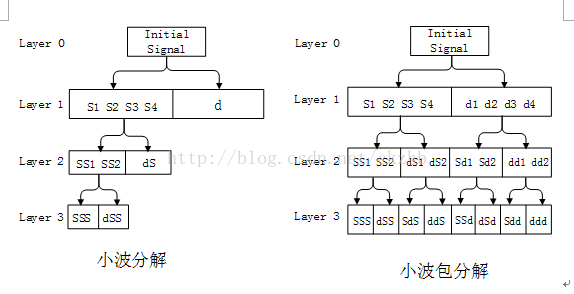

In [22]:
def DataAcquision(file_Path):
    """
    fun: 从cwru mat文件读取加速度数据
    param file_path: mat文件绝对路径
    return accl_data: 加速度数据，array类型
    """
    data = loadmat(file_Path)  
    data_key_list = list(data.keys())  
    accl_key = data_key_list[3]  # 获取'DE_time'
    accl_data = data[accl_key].flatten()  
    return accl_data

In [23]:
# 外圈数据

file_path = r'D:/MyWork/Compere/codes/时频故障特征提取/第3篇-小波包能量/1730_12k_0.007-InnerRace.mat'
data_arr = DataAcquision(file_path)

# 选用db1小波，分解层数为3
wp = pywt.WaveletPacket(data=data_arr, wavelet='db1', mode='symmetric', maxlevel=3)


In [24]:
# pywt.families() 小波家族

# 根据频段频率（freq）进行排序
print([node.path for node in wp.get_level(1, 'freq')]) # 第一层小波包节点
print([node.path for node in wp.get_level(2, 'freq')]) # 第二层小波包节点
print([node.path for node in wp.get_level(3, 'freq')]) # 第三层小波包节点

['a', 'd']
['aa', 'ad', 'dd', 'da']
['aaa', 'aad', 'add', 'ada', 'dda', 'ddd', 'dad', 'daa']


In [25]:
# 提取分解系数

aaa = wp['aaa'].data
print(aaa)
print('aaa的长度:',aaa.shape[0])
print('data_arr的长度:',data_arr.shape[0])
print('理论上第3层每个分解系数的长度:',data_arr.shape[0]/ (2**3))

[ 0.13742877  0.02521155 -0.30747749 ... -0.14569862 -0.28215109
  0.57900413]
aaa的长度: 15365
data_arr的长度: 122917
理论上第3层每个分解系数的长度: 15364.625


In [26]:
# 绘制每一层小波分解时域图
def wpd_plt(signal, n):
    wp = pywt.WaveletPacket(data=signal, wavelet='db1',mode='symmetric',maxlevel=n)
    
    # 计算每一个节点的系数，存在maps中，key为'aa'等，value为列表
    maps = {}
    maps[1] = signal # 原始信号
    for row in range(1, n+1):
        for i in [node.path for node in wp.get_level(row, 'freq')]:
            maps[i] = wp[i].data
            
    plt.figure(figsize=(15, 10))
    plt.subplot(n+1,1,1)
    plt.plot(maps[1])
    for i in range(2, n+2):
        level_num = pow(2, i-1) # 从第二行图开始，计算上一行图的2的幂次方
        re = [node.path for node in wp.get_level(i-1, 'freq')] 
        for j in range(1, level_num+1):
            plt.subplot(n+1, level_num, level_num*(i-1)+j)
            plt.plot(maps[re[j-1]])

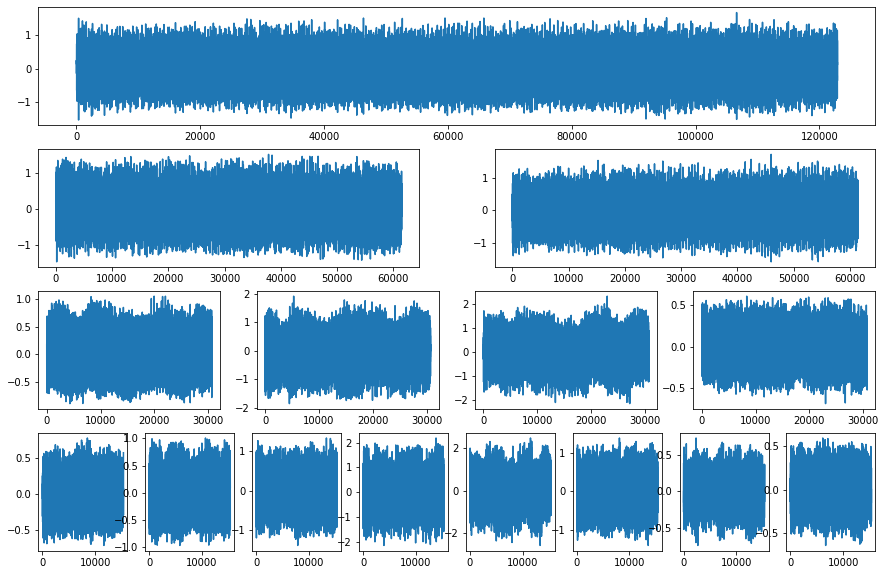

In [27]:
wpd_plt(signal=data_arr, n=3)

[601.1287769222096, 1166.6942072871639, 1574.8261014889365, 3020.0534245203094, 3624.086184449375, 1496.5850478295588, 317.91754565296947, 287.5823913938649]


<BarContainer object of 8 artists>

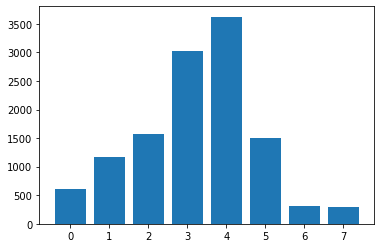

In [30]:
n = 3
re = [] # 第n层所有节点的分解系数
for i in [node.path for node in wp.get_level(n, 'freq')]:
    re.append(wp[i].data)
    
# 第n层能量特征:分解系数的范数
energy = []
for i in re:
    energy.append(pow(np.linalg.norm(i, ord=None), 2))
    
print(energy)

plt.bar(x=range(8), height=energy)

<BarContainer object of 8 artists>

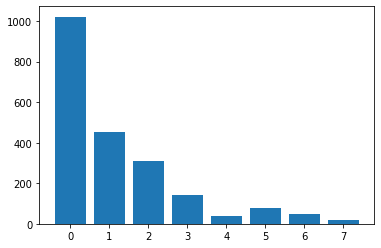

In [31]:
# 正常数据

file_path = r'D:/MyWork/Compere/codes/时频故障特征提取/第3篇-小波包能量/1730_48k_Normal.mat'
data_arr = DataAcquision(file_path)

wp = pywt.WaveletPacket(data=data_arr, wavelet='db1', mode='symmetric', maxlevel=3)

n = 3
re = [] # 第n层所有节点的分解系数
for i in [node.path for node in wp.get_level(n, 'freq')]:
    re.append(wp[i].data)
    
# 第n层能量特征:分解系数的范数
energy = []
for i in re:
    energy.append(pow(np.linalg.norm(i, ord=None), 2))
    
plt.bar(x=range(8), height=energy)

## 包络谱分析

In [34]:
from scipy import signal, fftpack, stats

# CWRU内圈故障
file_path = r'D:/MyWork/Compere/codes/时频故障特征提取/第4篇-包络谱/1730_12k_0.007-InnerRace.mat'
xt = DataAcquision(file_path)

### 希尔伯特黄变换
设$x(t)$为一个实时域信号，其Hilbert变换定义为：
$h(t)=\frac{1}{\pi} \int_{-\infty}^{+\infty} \frac{x(\tau)}{t-\tau} \mathrm{d} \tau=x(t) * \frac{1}{\pi t}$
则原始信号$x(t)$和它的Hilbert变换信号$h(t)$可以构建一个新的解析信号$z(t)$:
$z(t)=x(t)+j h(t)=a(t) e^{j \varphi t}$

In [36]:
# step1 : 希尔伯特变换
ht = fftpack.hilbert(xt)
print(len(xt), len(ht))

122917 122917


### 获得包络信号
对$z(t)$取模，得到其幅值$a(t):$

${a(t)=|z(t)|=\sqrt{x^{2}(t)+h^{2}(t)}}$

注：$a(t)$即为包络信号

In [37]:
# step2 : 包络信号
at = np.sqrt(ht**2 + xt**2)

### 获得包络谱
对包络信号做fft即为包络谱

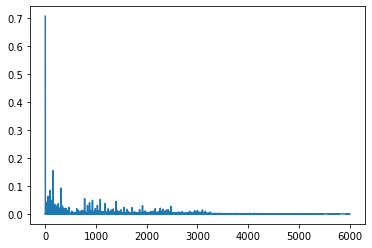

In [38]:
sampling_rate = 12000
am = np.fft.fft(at) # 对希尔伯特变换后的at做fft变换获得幅值
am = np.abs(am)
am = am / len(am)*2
am = am[0:int(len(am)/2)]
freq = np.fft.fftfreq(len(at), d=1/sampling_rate)  # 获取fft频率，此时包括正频率和负频率
freq = freq[0:int(len(freq)/2)] # 获取正频率

plt.plot(freq, am)

### 去直流分量
在0Hz的幅值比较高，使得其它频率幅值较低，不便观察。这种现象叫直流分量，去直流分量方法，y = y-mean(y)

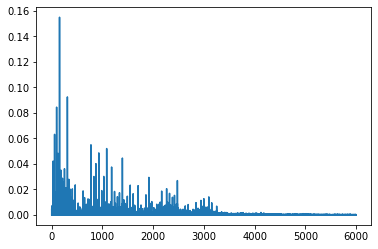

In [39]:
sampling_rate = 12000
at = at - np.mean(at)  # 去直流分量
am = np.fft.fft(at)    # 对希尔伯特变换后的at做fft变换获得幅值
am = np.abs(am)        # 对幅值求绝对值（此时的绝对值很大）
am = am/len(am)*2
am = am[0: int(len(am)/2)]
freq = np.fft.fftfreq(len(at), d=1 / sampling_rate)  # 获取fft频率，此时包括正频率和负频率
freq = freq[0:int(len(freq)/2)]  # 获取正频率
plt.plot(freq, am)

### 包络谱低频观察

(0.0, 500.0)

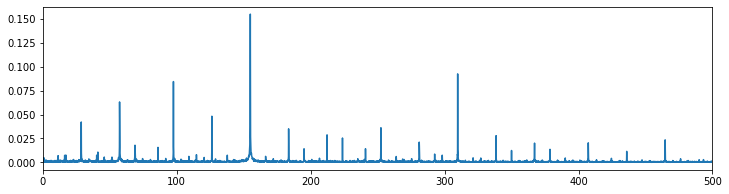

In [40]:
sampling_rate = 12000
at = at - np.mean(at)  # 去直流分量
am = np.fft.fft(at)    # 对希尔伯特变换后的at做fft变换获得幅值
am = np.abs(am)        # 对幅值求绝对值（此时的绝对值很大）
am = am/len(am)*2
am = am[0: int(len(am)/2)]
freq = np.fft.fftfreq(len(at), d=1 / sampling_rate)  # 获取fft频率，此时包括正频率和负频率
freq = freq[0:int(len(freq)/2)]  # 获取正频率
plt.figure(figsize=(12,3))
plt.plot(freq, am)
plt.xlim(0,500)

### 计算故障特征频率

内圈故障特征频率：$F_{\mathrm{BPFI}}=\frac{n f_{r}}{2}\left(1+\frac{d}{D} \cos \alpha\right)$

外圈故障特征频率：$F_{\mathrm{BPFO}}=\frac{n f_{r}}{2}\left(1-\frac{d}{D} \cos \alpha\right)$

滚动体故障特征频率：$F_{\mathrm{BSF}}=\frac{D f_{r}}{2 d}\left[1-\left(\frac{d}{D} \cos \alpha\right)^{2}\right]$

$n$: 滚动体个数，$f_{r}$: 轴转速 $d$: 滚珠(子)直径 $D$: 轴承节径

轴承型号为：6205-2RSL JME SKF 深沟球滚珠轴承

$d$=7.94mm, $D$=39.04mm, $\alpha$=0, $n$=9

In [42]:
def bearing_fault_freq_cal(n, d, D, alpha, fr=None):
    '''
    基本描述：
        计算滚动轴承的故障特征频率
    详细描述：
        输入4个参数 n, fr, d, D, alpha
    return C_bpfi, C_bpfo, C_bsf, C_ftf,  fr
           内圈    外圈    滚针   保持架  转速

    Parameters
    ----------
    n: integer
        The number of roller element
    fr: float(r/min)
        Rotational speed
    d: float(mm)
        roller element diameter
    D: float(mm)
        pitch diameter of bearing
    alpha: float(°)
        contact angle
    fr:：float(r/min)
        rotational speed
    Returns
    -------
    BPFI: float(Hz)
        Inner race-way fault frequency
    BPFO: float(Hz)
        Outer race-way fault frequency
    BSF: float(Hz)
        Ball fault frequency
    FTF: float(Hz)
        Cage frequency
    '''
    C_bpfi = n*(1/2)*(1+d/D*np.math.cos(alpha))
    C_bpfo = n*(1/2)*(1-(d/D)*np.math.cos(alpha))
    C_bsf = D*(1/(2*d))*(1-np.square(d/D*np.math.cos(alpha)))
    C_ftf = (1/2)*(1-(d/D)*np.math.cos(alpha))
    if fr!=None:
        return C_bpfi*fr/60, C_bpfo*fr/60, C_bsf*fr/60, C_ftf*fr/60, fr/60
    else:
        return C_bpfi, C_bpfo, C_bsf, C_ftf, fr

In [43]:
bpfi, bpfo, bsf, ftf, fr = bearing_fault_freq_cal(n=9, alpha=0, d=7.94, D=39.04, fr=1730)
print('内圈故障特征频率',bpfi)
print('外圈故障特征频率',bpfo)
print('滚动体故障特征频率',bsf)
print(ftf)
print(fr)

内圈故障特征频率 156.13870389344265
外圈故障特征频率 103.36129610655736
滚动体故障特征频率 67.9528924025478
11.48458845628415
28.833333333333332


#### 理论故障特征频率与实际故障特征频率验证

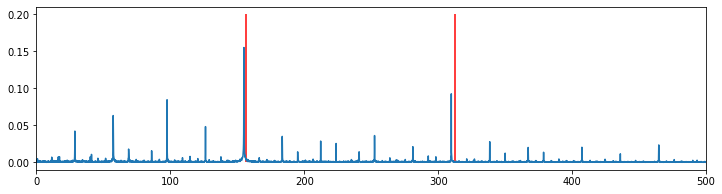

In [44]:
sampling_rate = 12000
at = at - np.mean(at)  # 去直流分量
am = np.fft.fft(at)    # 对希尔伯特变换后的at做fft变换获得幅值
am = np.abs(am)        # 对幅值求绝对值（此时的绝对值很大）
am = am/len(am)*2
am = am[0: int(len(am)/2)]
freq = np.fft.fftfreq(len(at), d=1 / sampling_rate)  # 获取fft频率，此时包括正频率和负频率
freq = freq[0:int(len(freq)/2)]  # 获取正频率
plt.figure(figsize=(12,3))
plt.plot(freq, am)
plt.xlim(0,500)

# 内圈故障特征频率 156.13870389344265
plt.vlines(x=156.13, ymin=0, ymax=0.2, colors='r')  # 一倍频
plt.vlines(x=156.13*2, ymin=0, ymax=0.2, colors='r')  # 二倍频

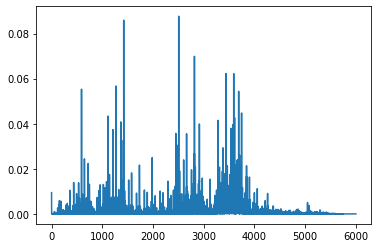

In [45]:
# 与FFT对比
sampling_rate = 12000
am = np.fft.fft(xt)   
am = np.abs(am)       
am = am/len(am)*2
am = am[0: int(len(am)/2)]
freq = np.fft.fftfreq(len(xt), d=1 / sampling_rate)  
freq = freq[0:int(len(freq)/2)]  
plt.plot(freq, am)

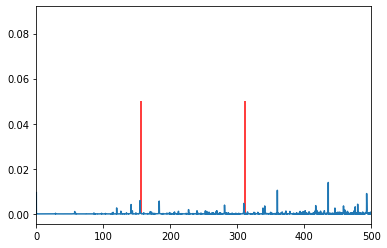

In [46]:
plt.plot(freq, am)
plt.xlim(0, 500)
plt.vlines(x=156.13, ymin=0, ymax=0.05, colors='r')  # 一倍频
plt.vlines(x=156.13*2, ymin=0, ymax=0.05, colors='r')  # 二倍频

#### 封装

In [51]:
# 封装
def plt_envelope_spectrum(data, fs, xlim=None, vline= None, ymax=0.2):
    '''
    fun: 绘制包络谱图
    param data: 输入数据，1维array
    param fs: 采样频率
    param xlim: 图片横坐标xlim，default = None
    param vline: 图片垂直线，default = None
    '''
    #----去直流分量----#
    data = data - np.mean(data)
    
    #----做希尔伯特变换----#
    xt = data
    ht = fftpack.hilbert(xt)
    at = np.sqrt(xt**2+ht**2)   # 获得解析信号at = sqrt(xt^2 + ht^2)
    am = np.fft.fft(at)         # 对解析信号at做fft变换获得幅值
    am = np.abs(am)             # 对幅值求绝对值（此时的绝对值很大）
    am = am/len(am)*2
    am = am[0: int(len(am)/2)]  # 取正频率幅值
    freq = np.fft.fftfreq(len(at), d=1 / fs)  # 获取fft频率，此时包括正频率和负频率
    freq = freq[0:int(len(freq)/2)]  # 获取正频率
    plt.plot(freq, am)
    if vline:  # 是否绘制垂直线
        plt.vlines(x=vline, ymax=ymax, ymin=0, colors='r')  # 高度y 0-0.2，颜色红色
    if xlim: # 图片横坐标是否设置xlim
        plt.xlim(0, xlim)  
    plt.xlabel('freq(Hz)')    # 横坐标标签
    plt.ylabel('amp(m/s2)')   # 纵坐标标签

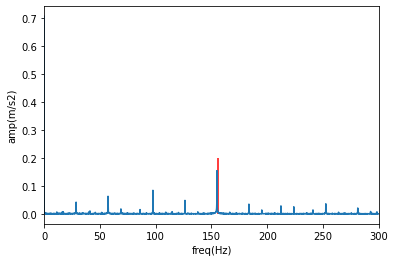

In [52]:
# 内圈故障数据测试
file_path = r'D:/MyWork/Compere/codes/时频故障特征提取/第4篇-包络谱/1730_12k_0.007-InnerRace.mat'
data = DataAcquision(file_path)

plt_envelope_spectrum(data = data, fs=12000, xlim=300, vline=bpfi)

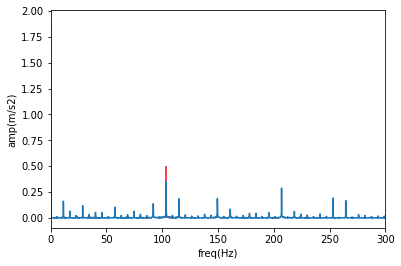

In [53]:
# 外圈故障数据测试
file_path = r'D:/MyWork/Compere/codes/时频故障特征提取/第4篇-包络谱/1730_12k_0.007-OuterRace3.mat'
data = DataAcquision(file_path)

plt_envelope_spectrum(data = data, fs=12000, xlim=300, vline=bpfo, ymax=0.5)

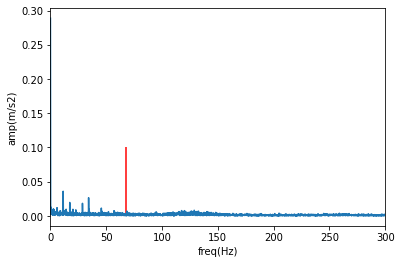

In [54]:
# 滚动体故障数据测试
file_path = r'D:/MyWork/Compere/codes/时频故障特征提取/第4篇-包络谱/1730_12k_0.014-Ball.mat'
data = DataAcquision(file_path)

plt_envelope_spectrum(data = data, fs=12000, xlim=300, vline=bsf, ymax=0.1)

## 概率密度函数

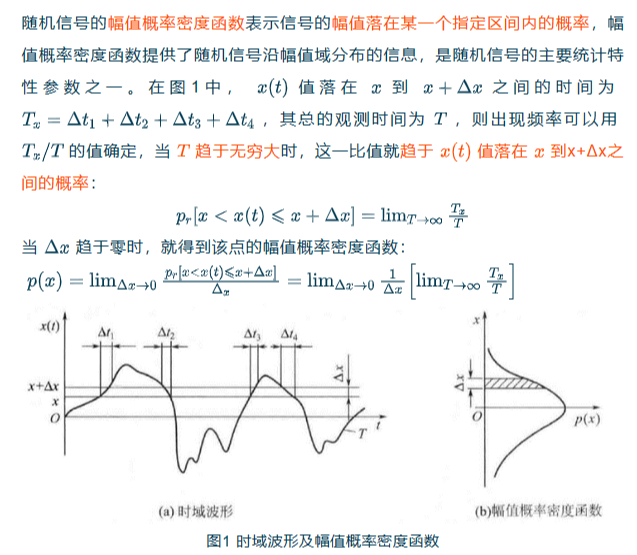

In [55]:
def interval_num_count(data, low, high):
    # 统计一维数据data落入某一个区间[low, high]内的数量
    count_num = 0
    for i in range(len(data)):
        if data[i] > low and data[i] < high:
            count_num += 1

    return count_num

def plt_amp_prob_density_fun(data, n):

    # n:区间数量

    data = data - np.mean(data) # 去直流分量（也叫零均值化处理）
    max_value = np.max(np.abs(data))  # 确定幅值绝对值最大值max_value
    interval_len = max_value * 2 / n # 区间间隔

    count_num_list = []
    for i in range(n):
        # 第i个幅值小区间[-max_value+i * interval_len, -max_value+(i+1) * interval_len]的下限
        low = -max_value + i*interval_len
        # 第i个幅值小区间[-max_value+i * interval_len, -max_value+(i+1) * interval_len]的上限
        high = -max_value + (i+1)*interval_len
        count_num = interval_num_count(data, low, high)
        count_num_list.append(count_num)
    
    plt.bar(x=range(len(count_num_list)), height=count_num_list)
    plt.show()

    
def plt_amp_prob_density_fun_norm(data, n):

    # n:区间数量

    data = data - np.mean(data) # 去直流分量（也叫零均值化处理）
    max_value = np.max(np.abs(data))  # 确定幅值绝对值最大值max_value
    interval_len = max_value * 2 / n # 区间间隔

    count_num_list = []
    for i in range(n):
        # 第i个幅值小区间[-max_value+i * interval_len, -max_value+(i+1) * interval_len]的下限
        low = -max_value + i*interval_len
        # 第i个幅值小区间[-max_value+i * interval_len, -max_value+(i+1) * interval_len]的上限
        high = -max_value + (i+1)*interval_len
        count_num = interval_num_count(data, low, high)
        count_num_list.append(count_num)
        
    count_num_list = np.array(count_num_list)
    count_num_list_sum = np.sum(count_num_list)
    count_num_list = count_num_list / count_num_list_sum

    plt.plot(np.linspace(-max_value, max_value, n), count_num_list)
    plt.show()
    


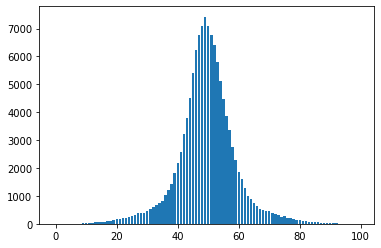

In [56]:
file_path = r'D:/MyWork/Compere/codes/时频故障特征提取/第4篇-包络谱/1730_12k_0.007-InnerRace.mat'
data = DataAcquision(file_path)

plt_amp_prob_density_fun(data, n=100)

# 序列切分

In [1]:
this_sample = list(range(6000)) # 序列长6000
X = []
for i in range(0, len(this_sample), 500): # 切分为3000长的子序列，步长500
    data_x = this_sample[i:i+3000]
    if len(data_x) == 3000:
        X.append(data_x)
        
len(X)

7

In [2]:
def train_y(y, num_classes=10):
    y_one = np.zeros(num_classes)
    y_one[int(y)] = 1
    return y_one

def data_processing_train():
    csv_file = pd.read_csv(train_path)# DataFram:792x6002 (id, feature1-6000, label)
    dataset = np.array(csv_file)
    
    data_pre = dataset[:,1:6001]
    label_pre = dataset[:, 6001]
    data_pre=data_pre.astype(np.float32)
    label_pre=label_pre.astype(np.float64)
    
    data = []
    label = []
    for i in range(data_pre.shape[0]):
        # 切分为维度3000，分割间隔为500
        # 对于每一条训练数据来说，可以数据增强为对应的七条训练数据 
        for j in range(7):
            data.append(data_pre[i][j*500:j*500+3000])
            label.append(label_pre[i])
    data = np.array(data)
    label = np.array(label)
    label = label.astype(np.uint8)
    label_transform = np.array([train_y(label[i]) for i in range(len(label))])
    
    index = [i for i in range(len(data))]
    np.random.shuffle(index)
    trX = data[index[:]]
    trY = label_transform[index[:]]
    teX = data[index[:]]
    teY = label_transform[index[:]]  
    return trX,trY,teX,teY
            
def data_processing_test():
    csv_file=pd.read_csv(test_path) # DataFram:528x6001
    dataset=np.array(csv_file)

    data_pre=dataset[:,1:6001] # float64 mnist:float32
    data_pre=data_pre.astype(np.float32)
    
    test_data=[]
    for i in range(data_pre.shape[0]):
        for j in range(7):
            test_data.append(data_pre[i][j*500:j*500+3000])
    
    # do not shuffle
    test_data=np.array(test_data)
    return test_data


"""
model.fit(trX,trY,batch_size=batch_size,epochs=epochs,validation_data=(teX,teY),verbose=1)
test_label=model.predict_classes(test_data)
label_process=test_label.reshape(528,7)

# 一个完整样本得到相应的七个子标签，将这七个标签进行投票，得到概率最大的类别作为该样本的标签
label=[]
for i in range(528):
    label.append([i+1,label_process[i][np.argmax(list(label_process[i]).count(x) for x in set(label_process[i]))]])
"""

'\nmodel.fit(trX,trY,batch_size=batch_size,epochs=epochs,validation_data=(teX,teY),verbose=1)\ntest_label=model.predict_classes(test_data)\nlabel_process=test_label.reshape(528,7)\n\n# 一个完整样本得到相应的七个子标签，将这七个标签进行投票，得到概率最大的类别作为该样本的标签\nlabel=[]\nfor i in range(528):\n    label.append([i+1,label_process[i][np.argmax(list(label_process[i]).count(x) for x in set(label_process[i]))]])\n'